<a href="https://colab.research.google.com/github/Arati930/ultrasound-nerve-segmentation/blob/main/ultra_sound_nerve_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install kaggle
from google.colab import files
files.upload()  # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c ultrasound-nerve-segmentation
!unzip ultrasound-nerve-segmentation.zip -d nerve_data


Saving kaggle (5).json to kaggle (5) (2).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open ultrasound-nerve-segmentation.zip, ultrasound-nerve-segmentation.zip.zip or ultrasound-nerve-segmentation.zip.ZIP.


In [18]:
# Install Kaggle
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
files.upload()  # Upload kaggle.json here

# Move the file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from the competition
!kaggle competitions download -c ultrasound-nerve-segmentation
!unzip -q ultrasound-nerve-segmentation.zip -d nerve_data


Saving kaggle (5).json to kaggle (5) (3).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open ultrasound-nerve-segmentation.zip, ultrasound-nerve-segmentation.zip.zip or ultrasound-nerve-segmentation.zip.ZIP.


In [19]:
from google.colab import files
uploaded = files.upload()

# Rename the uploaded file to kaggle.json (auto-detect name)
import os
for fn in uploaded.keys():
    os.rename(fn, "kaggle.json")


Saving kaggle (5).json to kaggle (5) (4).json


In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [21]:
!kaggle competitions download -c ultrasound-nerve-segmentation
!unzip -q ultrasound-nerve-segmentation.zip -d nerve_data


 99% 2.08G/2.11G [00:24<00:00, 99.8MB/s]
100% 2.11G/2.11G [00:25<00:00, 90.5MB/s]


In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_data(data_path, limit=None):
    images, masks = [], []
    image_files = os.listdir(os.path.join(data_path, 'train'))
    image_files = [f for f in image_files if '_mask' not in f][:limit]

    for fname in image_files:
        img_path = os.path.join(data_path, 'train', fname)
        mask_path = img_path.replace('.tif', '_mask.tif')

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
            images.append(image)
            masks.append(mask)

    X = np.expand_dims(np.array(images), -1)
    Y = np.expand_dims(np.array(masks), -1)
    return X, Y

X, Y = load_data('nerve_data', limit=1000)
print(f"Loaded {len(X)} image-mask pairs.")


Loaded 1000 image-mask pairs.


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    return models.Model(inputs, outputs)

model = build_unet((IMG_HEIGHT, IMG_WIDTH, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 96)     │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │         27,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 32)   │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 48)   │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 16)   │          6,928 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 1)    │             17 │ conv2d_6[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,489 (271.44 KB)

 Trainable params: 69,489 (271.44 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X, Y, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.8368 - loss: 0.5069 - val_accuracy: 0.9867 - val_loss: 0.1032
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9873 - loss: 0.0992 - val_accuracy: 0.9867 - val_loss: 0.0849
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9871 - loss: 0.0785 - val_accuracy: 0.9867 - val_loss: 0.0705
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9884 - loss: 0.0615 - val_accuracy: 0.9867 - val_loss: 0.0633
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9866 - loss: 0.0626 - val_accuracy: 0.9867 - val_loss: 0.0592
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9883 - loss: 0.0541 - val_accuracy: 0.9867 - val_loss: 0.0571
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9879 - loss: 0.0527 - val_accuracy: 0.9867 - val_loss: 0.0564
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9868 - loss: 0.0560 - val_accuracy: 0.9867 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


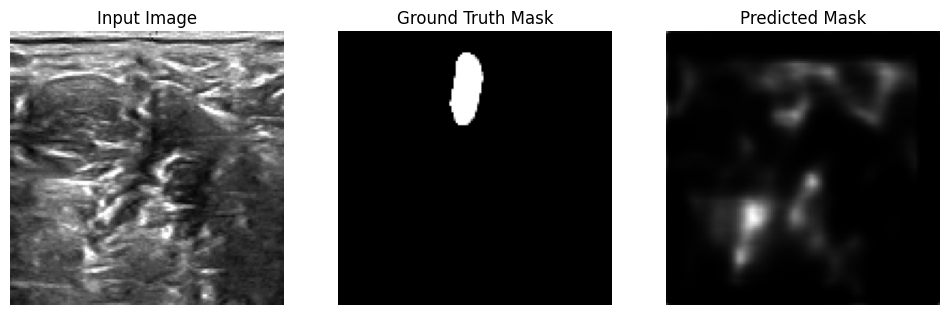

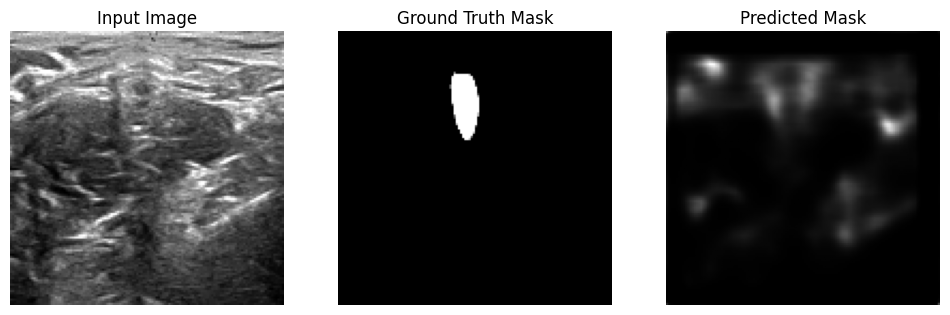

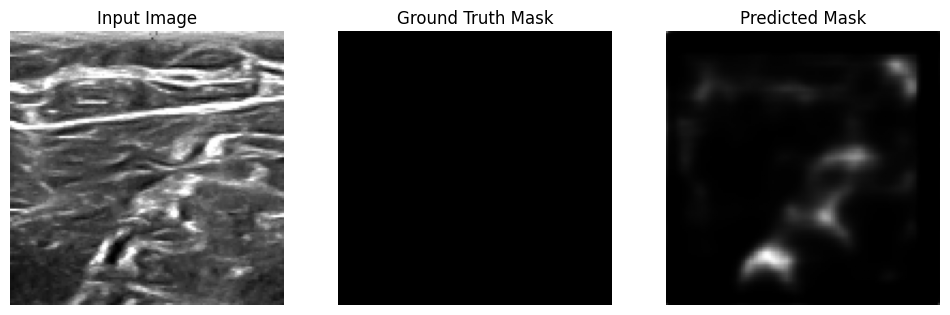

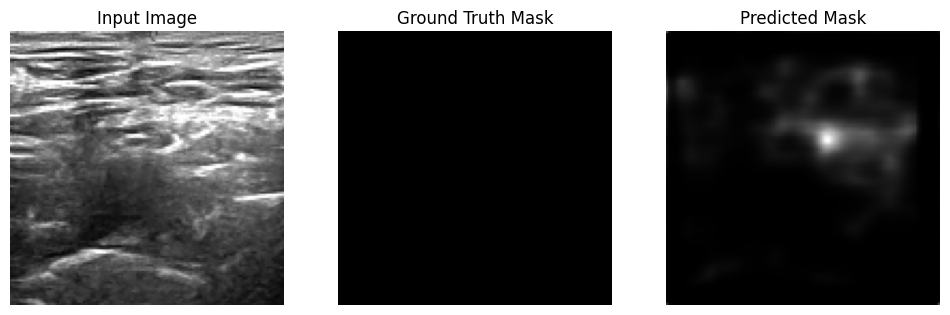

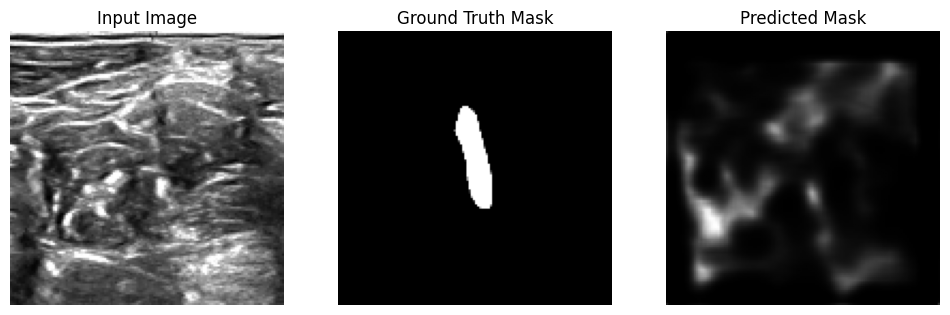

In [25]:
import matplotlib.pyplot as plt

# Predict on a few samples
preds = model.predict(X[:5])

# Visualize inputs, ground truths, and predictions
for i in range(5):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(Y[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()


In [26]:
model.save("ultrasound_nerve_segmentation_model.h5")


In [27]:
from google.colab import files
files.download("ultrasound_nerve_segmentation_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


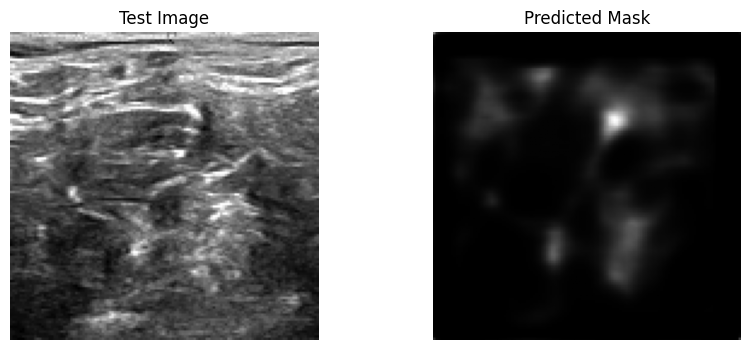

In [28]:
test_image_path = 'nerve_data/test/554.tif'  # Use any image name from test folder
test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (128, 128)) / 255.0
test_input = np.expand_dims(test_img, axis=(0, -1))  # shape (1, 128, 128, 1)

prediction = model.predict(test_input)[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Test Image")
plt.imshow(test_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(prediction.squeeze(), cmap='gray')
plt.axis('off')
plt.show()
